## Bibliotecas utilizadas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin # Para definição de transformadores personalizados
from sklearn.preprocessing import OneHotEncoder, Imputer, FunctionTransformer, StandardScaler
# from category_encoders import OrdinalEncoder
from future_encoders import OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
import time
from IPython.display import display

from sklearn.externals import joblib
import os

# 1. Introdução

Avito é a maior página russa de classificados de produtos e serviços, aos moldes do Craigslist. Desde de 2015, a companhia lança desafios anuais no Kaggle, uma plataforma que promove competições envolvendo análise de dados. Nesses desafíos, a Avito disponibiliza parte de seus dados para que competidores extraiam conclusões e construam modelos capazes de aprimorar a plataforma.

No desafio desse ano, o objetivo proposto é desenvolver um modelo capaz de predizer quão efetivo um anúncio qualquer no site será. Para tal, são disponibilizados em formato tabular, uma série de dados pertinentes aos seus anúncios:

- `item_id`: 
   <br>Identificação do anúncio;<br><br>
- `user_id`: 
   <br>Identificação do vendedor;<br><br>
- `region`: 
   <br>Região em que o produto é oferecido;<br><br>
- `city`: 
   <br>Cidade em que o produto é oferecido;<br><br>
- `parent_category_name`: 
   <br>Categoria do anúncio;<br><br>
- `category_name`: 
   <br>Categoria detalhada do anúncio;<br><br>
- `param_1`: 
   <br>Parâmetro opcional de categorização do anúncio;<br><br>
- `param_2`:
   <br>Parâmetro opcional de categorização do anúncio;<br><br>
- `param_3`: 
   <br>Parâmetro opcional de categorização do anúncio;<br><br>
- `title`:
   <br>Título do anúncio;<br><br>
- `description`:
   <br>Descrição do anúncio;<br><br>
- `price`: 
   <br>Preço do produto;<br><br>
- `item_seq_number`: 
   <br>Número sequencial de anúncio para o usuário;<br><br>
- `activation_date`: 
   <br>Data em que o anúncio foi anunciado;<br><br>
- `user_type`:
   <br>Tipo de vendedor;<br><br>
- `image`:
   <br>Identificador da imagem no anúncio;<br><br>
- `image_top_1`:
   <br>Classificação da imagem;<br><br>
- `deal_probability`:
   <br>Variável alvo. Essa é a probabilidade que um anúncio tenha vendido algo. Não é binário, pois a empresa não é capaz de verificar todas as vendas.


Além desses dados, também são disponibilizados dados tabulares adicionais e imagens, mas nós iremos nos focar apenas nos atributos descritos previamente.

# 2. Carregando e explorando os dados

Vamos começar carregando os dados:

In [2]:
# Algumas categorias dos atributos param_X são númericos, mas não queremos que sejam interpretados como tal.
# Para convertê-los para strings, mas não converter indevidamentes NaNs,  usamos um mapa de conversão
converters = {key: lambda x: np.nan if not x else str(x) for key in ('param_1', 'param_2', 'param_3')}

df_train = pd.read_csv(
    './data/train.csv',
    parse_dates=['activation_date'],
    converters=converters                  
)

In [3]:
df_train.head(10)

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
1,2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
2,ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
3,02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
4,7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797
5,51e0962387f7,bbfad0b1ad0a,Татарстан,Чистополь,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Авто люлька,В хорошем состоянии,1300.0,9,2017-03-28,Private,eb6ad1231c59d3dc7e4020e724ffe8e4d302023ddcbb99...,796.0,0.80323
6,c4f260a2b48a,08f469d2e6f7,Нижегородская область,Нижний Новгород,Для дома и дачи,Ремонт и строительство,Сантехника и сауна,NaN,NaN,Водонагреватель 100 литров нержавейка плоский,Электро водонагреватель накопительный на 100 л...,11000.0,125,2017-03-23,Private,0330f6ac561f5db1fa8226dd5e7e127b5671d44d075a98...,2823.0,0.00000
7,6b71309d6a8a,fef86baa002c,Пермский край,Пермь,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Джинсы,26,Бойфренды colins,Бойфренды в хорошем состоянии.,500.0,61,2017-03-25,Private,9bab29a519e81c14f4582024adfebd4f11a4ac71d323a6...,567.0,0.80323
8,c5b969cb63a2,055825270190,Оренбургская область,Оренбург,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,> 50 (XXL),Платье,54 раз мер очень удобное,500.0,85,2017-03-17,Private,75ce06d1f939a31dfb2af8ac55f08fa998fa336d13ee05...,415.0,0.00000
9,b1570962e68c,f9e8f831d94c,Нижегородская область,Нижний Новгород,Личные вещи,Детская одежда и обувь,Для девочек,Обувь,25,Полу ботиночки замш натур.Бамбини,По стельке 15.5см мерить приокский район. Цвет...,400.0,136,2017-03-22,Company,54fb8521135fda77a860bfd2fac6bf46867ab7c06796e3...,46.0,0.00000


Podemos ver que a maior parte dos atributos é não-numérico e categórico. Portanto, serão necessárias transformações para codificá-las. Vamos contar o número de classes por atributo categórico:

In [3]:
print('Regions:', len(np.unique(df_train['region'])))
print('cities:', len(np.unique(df_train['city'])))
print('parent_category_names:', len(np.unique(df_train['parent_category_name'])))
print('category_names:', len(np.unique(df_train['category_name'])))
print('param_1:', len(np.unique(df_train['param_1'][~pd.isnull(df_train['param_1'].values)].values)))
print('param_1:', len(np.unique(df_train['param_1'].astype(str).values)))
print('param_2:', len(np.unique(df_train['param_2'][~pd.isnull(df_train['param_2'].values)].values)))
print('param_3:', len(np.unique(df_train['param_3'][~pd.isnull(df_train['param_3'].values)].values)))
print('activation_dates:', len(np.unique(df_train['activation_date'])))
print('user_types:', len(np.unique(df_train['user_type'])))

Regions: 28
cities: 1733
parent_category_names: 9
category_names: 47
param_1: 371
param_1: 372
param_2: 271
param_3: 1219
activation_dates: 21
user_types: 3


Há um grande número de classes. Efetuar One-hot Encoding aumentaria em muito o número de atributos e exigiria dos algoritmos de treino um tempo impraticável para gerarmos modelos. Portanto, teremos de nos limitar a uma codificação ordinal.

É possível ver também que temos várias instâncias com dados faltantes. Remoção dessas instâncias não parece ser uma opção, pelo grande número que teria de ser eliminado. Teremos de fazer, então, algumas imputações:

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503424 entries, 0 to 1503423
Data columns (total 18 columns):
item_id                 1503424 non-null object
user_id                 1503424 non-null object
region                  1503424 non-null object
city                    1503424 non-null object
parent_category_name    1503424 non-null object
category_name           1503424 non-null object
param_1                 1441848 non-null object
param_2                 848882 non-null object
param_3                 640859 non-null object
title                   1503424 non-null object
description             1387148 non-null object
price                   1418062 non-null float64
item_seq_number         1503424 non-null int64
activation_date         1503424 non-null datetime64[ns]
user_type               1503424 non-null object
image                   1390836 non-null object
image_top_1             1390836 non-null float64
deal_probability        1503424 non-null float64
dtypes: datetim

Para termos uma ideia de suas distribuições, vamos plotar os atributos numéricos:

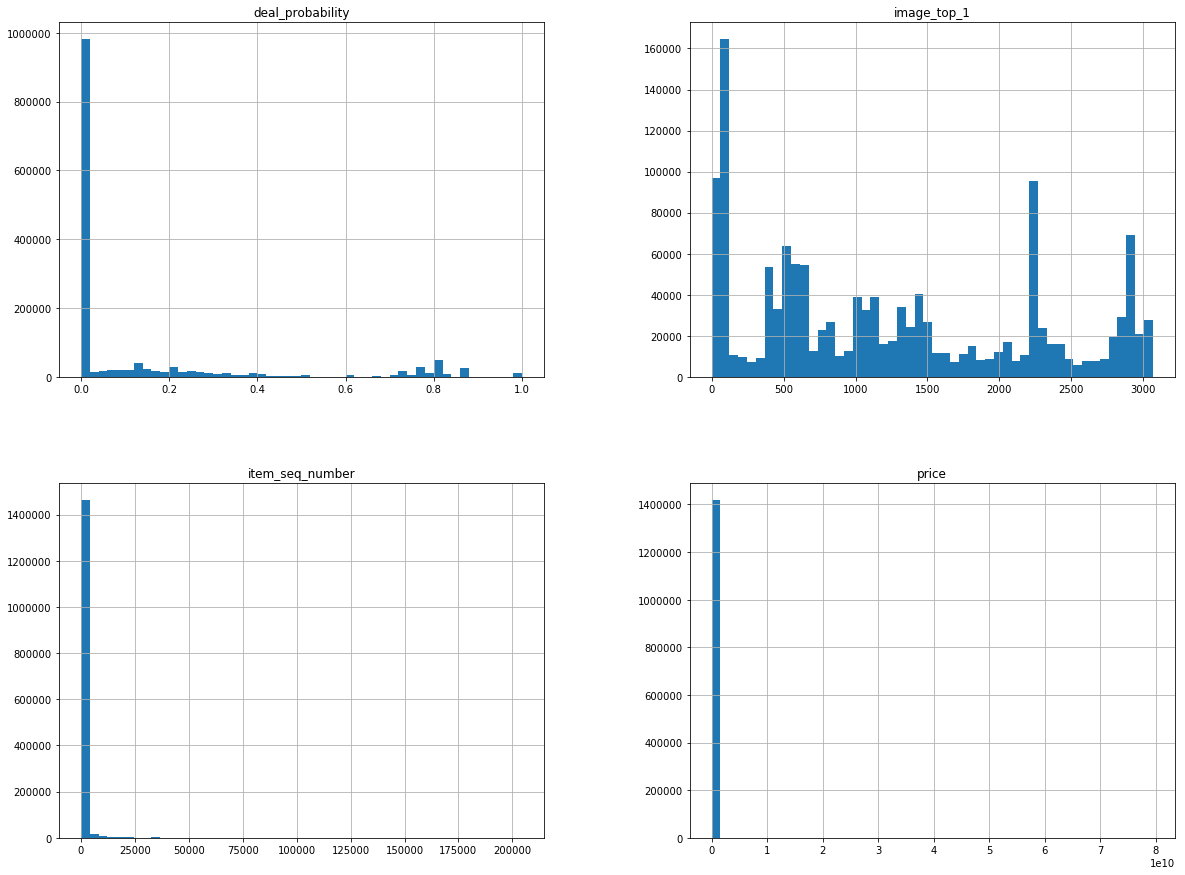

In [10]:
df_train.hist(bins=50, figsize=(20, 15))
plt.show()

Podemos ver a que a maioria das distribuições tendem para valores mais baixos (distribuições chamadas *tail heavy*).

Por fim, vamos repartir o dataset em um DataFrame de treino e um vetor da função alvo:

In [11]:
X, y = df_train[df_train.columns.difference(['deal_probability'])].copy(), df_train[['deal_probability']].copy()

# 3. Processando dados

Com base nessa primeira observação dos dados, podemos ver que algumas transformações terão de ser aplicadas antes de desenvolver qualquer modelo. Alguns atributos não parecem ter grande valor para nosso objetivo, como `user_id`. Além disso, várias entradas têm dados faltantes, o que exigirá uma série de imputações. Ainda, temos uma mistura de dados categóricos e textuais que exigirão diferentes transformações de codificação.

Iremos fazer uso de Pipelines do Scikit Learn para criar objetos que encadeiam todas as nossas trasformações e podem ser reutilizados mais facilmente nos dados de validação. Inicialmente, vamos definir transformadores auxiliares para selecionar atributos de um DataFrame e construir DataFrames, a serem utilizados pelos transformadores subsequentes:

In [5]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names, as_ndarray=False):
        self.attribute_names = attribute_names
        self.as_ndarray = as_ndarray
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names] if not self.as_ndarray else X[self.attribute_names].values
    
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns)

## 3.1. Removendo atributos

O dataset tem alguns atributos que não são exatamente úteis para nossa modelagem, como `item_id` e `user_id` Ainda, não faremos qualquer processamento de imagens. então, o atributo de identificadores de imagens, `image` não nos tem serventia.Vamos declarar um seletor inicial, responsável por produzir um DataFrame sem esses atributos. Esse DataFrame servirá de base para nossas transfomações posteriores:

In [6]:
features_selector = DataFrameSelector(X.columns.difference(['item_id', 'user_id', 'image']))

Quando aplicado ao dataset, temos:

In [6]:
X_transf = features_selector.transform(X)

In [7]:
X_transf.head()

,activation_date,category_name,city,description,image_top_1,item_seq_number,param_1,param_2,param_3,parent_category_name,price,region,title,user_type
0,2017-03-28,Товары для детей и игрушки,Екатеринбург,"Кокон для сна малыша,пользовались меньше месяц...",1008.0,2,Постельные принадлежности,NaN,NaN,Личные вещи,400.0,Свердловская область,Кокоби(кокон для сна),Private
1,2017-03-26,Мебель и интерьер,Самара,"Стойка для одежды, под вешалки. С бутика.",692.0,19,Другое,NaN,NaN,Для дома и дачи,3000.0,Самарская область,Стойка для Одежды,Private
2,2017-03-20,Аудио и видео,Ростов-на-Дону,"В хорошем состоянии, домашний кинотеатр с blu ...",3032.0,9,"Видео, DVD и Blu-ray плееры",NaN,NaN,Бытовая электроника,4000.0,Ростовская область,Philips bluray,Private
3,2017-03-25,Товары для детей и игрушки,Набережные Челны,Продам кресло от0-25кг,796.0,286,Автомобильные кресла,NaN,NaN,Личные вещи,2200.0,Татарстан,Автокресло,Company
4,2017-03-16,Автомобили,Волгоград,Все вопросы по телефону.,2264.0,3,С пробегом,ВАЗ (LADA),2110,Транспорт,40000.0,Волгоградская область,"ВАЗ 2110, 2003",Private


## 3.2. Tratando datas

O atributo `activation_date`, em sua forma atual, não é muito útil. Identificar variações na probabilidade de sucesso de venda em relação à uma data específica dificilmente irá ser muito aplicável a dados desconhecidos. Por outro lado, se repartirmos esse atributo em vertentes mais gerais, possivelmente consiguiremos incorporar conhecimento mais geral em nossos modelos. Com isso em mente, criaremos três novos atributos a partir de `activation_date`: `month`, `day` e `weekday`:  

In [7]:
# Essa transformação espera uma única série de timestamps e retorna um DataFrame
class TimestampTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(
            np.c_[
                X.dt.month,
                X.dt.day,
                X.dt.weekday
            ],
            columns=['month', 'day', 'weekday']
        )

Quando aplicamos esse transformador ao dataset, obtemos:

In [8]:
process_date = Pipeline([
    ('date_series_selector', DataFrameSelector('activation_date')),
    ('date_features_transformer', TimestampTransformer())
])

X_test = process_date.transform(X)

In [9]:
X_test.head()

,month,day,weekday
0,3,28,1
1,3,26,6
2,3,20,0
3,3,25,5
4,3,16,3


## 3.2. Imputando dados faltantes

Para o atributo de preço, vamos imputar a média dos valores conhecidos:

In [10]:
price_imputer = Imputer(strategy='mean')

process_price = Pipeline([
    ('price_selector', DataFrameSelector(['price'])),
    ('price_imputer', price_imputer),
    ('to_data_frame', ToDataFrameTransformer(['price']))
])

Quando aplicado ao dataset, obtemos:

In [12]:
X_price = process_price.fit_transform(X)

In [13]:
X_price.head()

,price
0,400.0
1,3000.0
2,4000.0
3,2200.0
4,40000.0


Para o atributo `image_top_1` vamos imputar o valor mais frequente:

In [11]:
image_imputer = Imputer(strategy='most_frequent')

process_image_class = Pipeline([
    ('image_selector', DataFrameSelector(['image_top_1'])),
    ('image_imputer', image_imputer),
    ('to_data_frame', ToDataFrameTransformer(['image_top_1']))
])

In [12]:
X_image = process_image_class.fit_transform(X)

In [16]:
X_image.head()

,image_top_1
0,1008.0
1,692.0
2,3032.0
3,796.0
4,2264.0


Para atributos categóricos, vamos também adotar a estratégia de imputar a classe mais frequente para cada coluna. No entanto, o imputador do Scikit Learn não consegue lidar com colunas não numéricas. Vamos então declarar um imputador personalizado para essa operação:

In [13]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series(X.values.ravel()).value_counts().index[0]
        return self
        
    def transform(self, X):
        return pd.DataFrame(pd.Series(X.values.ravel()).fillna(self.most_frequent))

In [14]:
impute_cat = Pipeline([
    ('cat_imputer', FeatureUnion([
        ('region_imputer', Pipeline([
            ('region_selector', DataFrameSelector('region')),
            ('region_imputer', CategoricalImputer())
        ])),
        ('city_imputer', Pipeline([
            ('city_selector', DataFrameSelector('city')),
            ('city_imputer', CategoricalImputer())
        ])),
        ('parent_category_name_imputer', Pipeline([
            ('parent_category_name_selector', DataFrameSelector('parent_category_name')),
            ('parent_category_name_imputer', CategoricalImputer())
        ])),
        ('category_name_imputer', Pipeline([
            ('category_name_selector', DataFrameSelector('category_name')),
            ('category_name_imputer', CategoricalImputer())
        ])),
        ('param_1_imputer', Pipeline([
            ('param_1_selector', DataFrameSelector('param_1')),
            ('param_1_imputer', CategoricalImputer())
        ])),
        ('param_2_imputer', Pipeline([
            ('param_2_selector', DataFrameSelector('param_2')),
            ('param_2_imputer', CategoricalImputer())
        ])),
        ('param_3_imputer', Pipeline([
            ('param_3_selector', DataFrameSelector('param_3')),
            ('param_3_imputer', CategoricalImputer())
        ])),
        ('user_type_imputer', Pipeline([
            ('user_type_selector', DataFrameSelector('user_type')),
            ('user_type_imputer', CategoricalImputer())
        ])),   
    ])),
    ('to_data_frame', ToDataFrameTransformer([
        'region',
        'city',
        'parent_category_name',
        'category_name',
        'param_1',
        'param_2',
        'param_3',
        'user_type'
    ]))
])

In [19]:
X = impute_cat.fit_transform(X)

In [20]:
X.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,user_type
0,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,Обувь,Вторичка,Private
1,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,Обувь,Вторичка,Private
2,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",Обувь,Вторичка,Private
3,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,Обувь,Вторичка,Company
4,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,Private


Finalmente, iremos preencher as células vazias da coluna *description* com strings vazias:

In [15]:
class TextImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return pd.DataFrame(X.fillna(''))

In [16]:
process_description = Pipeline([
    ('description_selector', DataFrameSelector('description')),
    ('imputer', TextImputer())
])

In [23]:
X = process_description.transform(X)

In [24]:
X.head()

,description
0,"Кокон для сна малыша,пользовались меньше месяц..."
1,"Стойка для одежды, под вешалки. С бутика."
2,"В хорошем состоянии, домашний кинотеатр с blu ..."
3,Продам кресло от0-25кг
4,Все вопросы по телефону.


## 3.3. Codificando atributos categóricos

Por limitação do Scikit learn, não podemos treinar modelos com matrizes de treino com dados não numéricos. Portanto, teremos que codificar numericamente os atributos categóricos, associando a cada categoria, um número.

In [17]:
encode_cat = Pipeline([
    ('cat_selector', DataFrameSelector([
        'region',
        'city',
        'parent_category_name',
        'category_name',
        'param_1',
        'param_2',
        'param_3',
        'user_type'
    ])),
    ('ordinal_encoder', OrdinalEncoder(dtype=np.int64)),
    ('to_data_frame', ToDataFrameTransformer([
        'region',
        'city',
        'parent_category_name',
        'category_name',
        'param_1',
        'param_2',
        'param_3',
        'user_type'
    ]))
])

In [26]:
start = time.time()

X_transf = Pipeline([('impute', impute_cat), ('encode', encode_cat)]).fit_transform(X)

end = time.time()
print('Elapsed time:', end-start)

Elapsed time: 33.73176097869873


In [27]:
X_transf.head()

,region,city,parent_category_name,category_name,param_1,param_2,param_3,user_type
0,19,460,4,42,248,192,1173,1
1,17,1300,2,22,121,192,1173,1
2,16,1276,0,2,83,192,1173,1
3,21,940,4,42,37,192,1173,0
4,4,317,6,0,277,118,44,1


## 3.4. Codificando atributos textuais 

Pelos mesmos motivos que os atributos categóricos, teremos de codificar os atributos textuais `title` e `description`. Iremos usar o modelo *Bag of words* para efeturar essa codificação, aplicando tf-idf para ???. Por fim, aplicamos uma transformação SVD para reduzir a dimensão da codificação. Do contrário, nosso dataset ganharia milhares de novos atributos e dificultaria o treino dos modelos.

In [18]:
vect = TfidfVectorizer(sublinear_tf=True)

encode_title = Pipeline([
    ('title_selector', DataFrameSelector(['title'])),
    ('ravel_feature', FunctionTransformer(lambda f: f.values.ravel(), validate=False)),
    ('text_vectorizer', vect),
    ('dim_reduction', TruncatedSVD(random_state=1))
])

encode_description = Pipeline([
    ('description_selector', DataFrameSelector('description')),
    ('description_imputer', TextImputer()),
    ('ravel_feature', FunctionTransformer(lambda f: f.values.ravel(), validate=False)),
    ('text_vectorizer', vect),
    ('dim_reduction', TruncatedSVD(random_state=1))
])

encode_text = Pipeline([
    ('process_text', FeatureUnion([
        ('process_title', encode_title),
        ('process_description', encode_description)
    ])),
    ('to_data_frame', ToDataFrameTransformer(['title_svd_1', 'title_svd_2', 'description_svd_1', 'description_svd_2']))
])

In [29]:
start = time.time()

text_processed = encode_text.fit_transform(X)

end = time.time()

print('Elapsed time:', end - start)

Elapsed time: 68.30051064491272


In [30]:
text_processed.head()

,title_svd_1,title_svd_2,description_svd_1,description_svd_2
0,0.000258,0.006233,0.031400,0.034607
1,0.000457,0.010049,0.019601,0.024246
2,0.000021,0.000026,0.150786,-0.053959
3,0.000052,0.000226,0.036863,0.026788
4,0.000011,-0.000020,0.116715,0.134761


## 3.5. Unindo os transformadores

Por fim, vamos unir todos os transformadores em um único pipeline de preprocessamento, que pode ser reutizado pelos dados de validação:

In [19]:
preprocess_transformer = Pipeline([
    ('working_feature_selector', features_selector),
    ('date_transf', FeatureUnion([
        ('other_features', DataFrameSelector(['category_name', 'city', 'description',
       'image_top_1', 'item_seq_number', 'param_1', 'param_2', 'param_3',
       'parent_category_name', 'price', 'region', 'title', 'user_type'])),
        ('process_date', process_date),
    ])),
    ('to_data_frame_1', ToDataFrameTransformer([['category_name', 'city', 'description',
       'image_top_1', 'item_seq_number', 'param_1', 'param_2', 'param_3',
       'parent_category_name', 'price', 'region', 'title', 'user_type', 'month', 'day', 'weekday']])),
    ('imputers', FeatureUnion([
        ('other_features', DataFrameSelector(['item_seq_number', 'title', 'month', 'day', 'weekday'])),
        ('impute_price', process_price),
        ('impute_image', process_image_class),
        ('impute_cat', impute_cat),
        ('impute_description', process_description)
    ])),
    ('to_data_frame_2', ToDataFrameTransformer([
        'item_seq_number',
        'title',
        'month',
        'day',
        'weekday',
        'price',
        'image_top_1',
        'region',
        'city',
        'parent_category_name',
        'category_name',
        'param_1',
        'param_2',
        'param_3',
        'user_type',
        'description'
    ])),
    ('encoders', FeatureUnion([
        ('other_features', DataFrameSelector(['item_seq_number', 'month', 'day', 'weekday', 'price', 'image_top_1'])),
        ('encode_cat', encode_cat),
        ('encode_text', encode_text)
    ])),
    ('to_data_frame_3', ToDataFrameTransformer([
        'item_seq_number',
        'month',
        'day',
        'weekday',
        'price',
        'image_top_1',
        'region',
        'city',
        'parent_category_name',
        'category_name',
        'param_1',
        'param_2',
        'param_3',
        'user_type',
        'title_svd_1',
        'title_svd_2',
        'description_svd_1',
        'description_svd_2'
    ]))
])

In [20]:
start = time.time()
X_processed = preprocess_transformer.fit_transform(X)
end = time.time()

print('Elapsed time:', end - start)

Elapsed time: 117.67687249183655


In [21]:
X_processed.head()

,item_seq_number,month,day,weekday,price,image_top_1,region,city,parent_category_name,category_name,param_1,param_2,param_3,user_type,title_svd_1,title_svd_2,description_svd_1,description_svd_2
0,2,3,28,1,400,1008,19,460,4,42,248,192,1173,1,0.00025798,0.00623332,0.0314004,0.0346072
1,19,3,26,6,3000,692,17,1300,2,22,121,192,1173,1,0.000457325,0.0100489,0.0196006,0.0242461
2,9,3,20,0,4000,3032,16,1276,0,2,83,192,1173,1,2.09619e-05,2.58056e-05,0.150786,-0.0539593
3,286,3,25,5,2200,796,21,940,4,42,37,192,1173,0,5.20505e-05,0.000226047,0.0368626,0.0267884
4,3,3,16,3,40000,2264,4,317,6,0,277,118,44,1,1.06665e-05,-2.04614e-05,0.116715,0.134761


Salvando os dados processados:

In [3]:
loc = os.path.dirname('__file__')

In [24]:
filename = 'data/X_train_processed.sav'

joblib.dump(X_processed, open(os.path.join(loc, filename), 'wb'))

Teste carregamento:

In [7]:
X_processed = joblib.load('data/X_train_processed.sav')

In [5]:
X_processed.head()

,item_seq_number,month,day,weekday,price,image_top_1,region,city,parent_category_name,category_name,param_1,param_2,param_3,user_type,title_svd_1,title_svd_2,description_svd_1,description_svd_2
0,2,3,28,1,400,1008,19,460,4,42,248,192,1173,1,0.00025798,0.00623332,0.0313975,0.0345895
1,19,3,26,6,3000,692,17,1300,2,22,121,192,1173,1,0.000457325,0.0100489,0.019601,0.0242359
2,9,3,20,0,4000,3032,16,1276,0,2,83,192,1173,1,2.09619e-05,2.58056e-05,0.150771,-0.0540722
3,286,3,25,5,2200,796,21,940,4,42,37,192,1173,0,5.20505e-05,0.000226047,0.0368607,0.0267437
4,3,3,16,3,40000,2264,4,317,6,0,277,118,44,1,1.06665e-05,-2.04614e-05,0.116751,0.134437


Finalmente, vamos repartir o modelo em um conjunto de treino e outro de testes:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_processed.values, y.values.ravel(), test_size=.2, random_state=1)

In [24]:
df = pd.DataFrame(X_test)

array([ 0.06409,  0.23907,  0.08918, ...,  0.86521,  0.     ,  0.     ])

In [23]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,3,17,4,4000,2296,19,460,4,29,206,121,163,1,0.00032278,0.00157943,0.184173,-0.0305854
1,58,3,20,0,316708,2219,18,1305,3,43,125,192,1173,1,4.8104e-05,0.000148465,0.0564575,0.135091
2,6,3,25,5,700,413,17,1623,4,29,125,227,212,1,2.33806e-05,0.000154604,0.0172112,0.0218057
3,17,3,17,4,800,84,24,545,4,10,104,157,172,1,0.00149594,0.00659424,0.162879,0.0505661
4,62,3,19,6,2250,2911,9,1387,0,41,40,145,1173,0,3.03363e-05,7.4217e-05,0.0195368,0.0244472


# 4. Treinando modelos

## 4.1 Árvore de decisão

In [13]:
tree_regressor = DecisionTreeRegressor(random_state=1)

In [14]:
grid_params = {
    'max_depth': np.arange(11, 16),
    'min_samples_split': np.linspace(0.0001, .01, 5, endpoint=True),
}

grid_search_tree = GridSearchCV(tree_regressor, param_grid=grid_params, cv=5, scoring='neg_mean_squared_error', n_jobs=4)

In [15]:
start = time.time()

grid_search_tree.fit(X_train, y_train)

end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  601.2647848129272


Vamos ver os melhores parâmetros obtidos:

In [16]:
grid_search_tree.best_params_

{'max_depth': 15, 'min_samples_split': 0.002575}

E o menor erro obtido:

In [17]:
tree_rmse = np.sqrt(-grid_search_tree.best_score_)
print(tree_rmse)

0.233924405371


Agora, vamos avaliar no conjunto de testes:

In [27]:
y_pred = grid_search_tree.best_estimator_.predict(X_test)

In [29]:
tree_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(tree_test_rmse)

0.233723778099


Salvando o modelo:

In [34]:
filename = 'models/decision_tree.sav'
joblib.dump(grid_search_tree.best_estimator_, open(filename, 'wb'))

In [46]:
y_pred[np.where(np.logical_or(y_pred < 0, y_pred > 1))].size

0

## 4.2. Random Forest

In [9]:
rnd_forest_regressor = RandomForestRegressor()

In [16]:
grid_params = {
    'n_estimators': [100],
    'max_depth': [20, ],
}

grid_search_rnd_forest = GridSearchCV(
    rnd_forest_regressor,
    param_grid=grid_params,
    cv=5,
    scoring='neg_mean_squared_error',
    random_state=1
)

In [17]:
start = time.time()

grid_search_rnd_forest.fit(X_train_processed, y_train.values.ravel())

end = time.time()
print('Elapsed time: ', end - start)

Elapsed time:  12043.079990625381


Melhores parâmetros obtidos:

In [18]:
grid_search_rnd_forest.best_params_

{'max_depth': 20, 'n_estimators': 100}

E o menor erro:

In [19]:
rnd_forest_rmse = np.sqrt(-grid_search_rnd_forest.best_score_)
print(rnd_forest_rmse)

0.2273286383342149


Salvando o modelo:

In [20]:
filename = 'models/random_forest.sav'
joblib.dump(grid_search_rnd_forest.best_estimator_, open(filename, 'wb'))

## 4.3. Gradient Boosting

## 4.2 Support Vector machine

Começando com uma support vector machine linear:

In [46]:
linear_svr = LinearSVR(random_state=1)

svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', linear_svr)
])

In [47]:
svr_pipeline.fit(X_train_processed, y_train.values.ravel())

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('regressor', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=10,
     random_state=1, tol=0.0001, verbose=0))])

In [48]:
y_pred = svr_pipeline.predict(X_train_processed)

In [49]:
svr_rmse = np.sqrt(mean_squared_error(y_train, y_pred))

In [50]:
svr_rmse

0.34873575404963947